In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
import pandas as pd
import wfdb
import numpy as np
import os

base_path = r"C:\Vinh\CSSALT\CSSALT-waveform-classify-model\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
metadata_path = os.path.join(base_path, "ptbxl_database.csv")  

df = pd.read_csv(metadata_path)

ecg_segments = []

threshold = 5

for idx, row in df.iterrows():
    scp_codes = eval(row["scp_codes"])  

    if "NORM" not in scp_codes or abs(scp_codes["NORM"] - 100) > threshold:
        continue
    hr_path = os.path.join(base_path, row["filename_hr"])  

    record = wfdb.rdrecord(hr_path)

    ecg_signal = record.p_signal[:, 0]

    segment_size = 2000
    num_segments = len(ecg_signal) // segment_size  

    for i in range(num_segments):
        segment = ecg_signal[i * segment_size : (i + 1) * segment_size]
        ecg_segments.append(segment)

    if len(ecg_segments) >= 1000:
        break

ecg_segments = np.array(ecg_segments)
ecg_segments = ecg_segments * 1000

lr_ecg_segments = []
for ecg_segment in ecg_segments:
    lr_ecg_segment = []
    for i in range(len(ecg_segment)):
        if (i % 5 == 0):
            lr_ecg_segment.append(ecg_segment[i])
        elif (i % 5 == 2):
            lr_ecg_segment.append((ecg_segment[i] + ecg_segment[i + 1])/2)
    lr_ecg_segments.append(lr_ecg_segment)

lr_ecg_segments = np.array(lr_ecg_segments)

np.save(os.path.join(base_path, "lr_ecg_segments.npy"), lr_ecg_segments)

print(f"Extracted {len(lr_ecg_segments)} ECG segments of 800 samples each.")


Extracted 1000 ECG segments of 800 samples each.


In [3]:
lr_ecg_segments

array([[-115. , -115. , -115. , ...,  -43. ,    0. ,  -39. ],
       [ -50. ,  -55.5,    0. , ...,   46. ,  160. ,  129. ],
       [ -35. ,  -35. ,  -35. , ...,  -24.5,    0. ,  -32. ],
       ...,
       [ -70. ,  -65. ,  -60. , ..., -169.5, -170. , -143.5],
       [ -50. ,  -50. ,  -50. , ...,  -59.5,  -60. ,  -60. ],
       [ -60. ,  -60. ,  -60. , ...,  -65.5,  -65. ,  -64.5]])

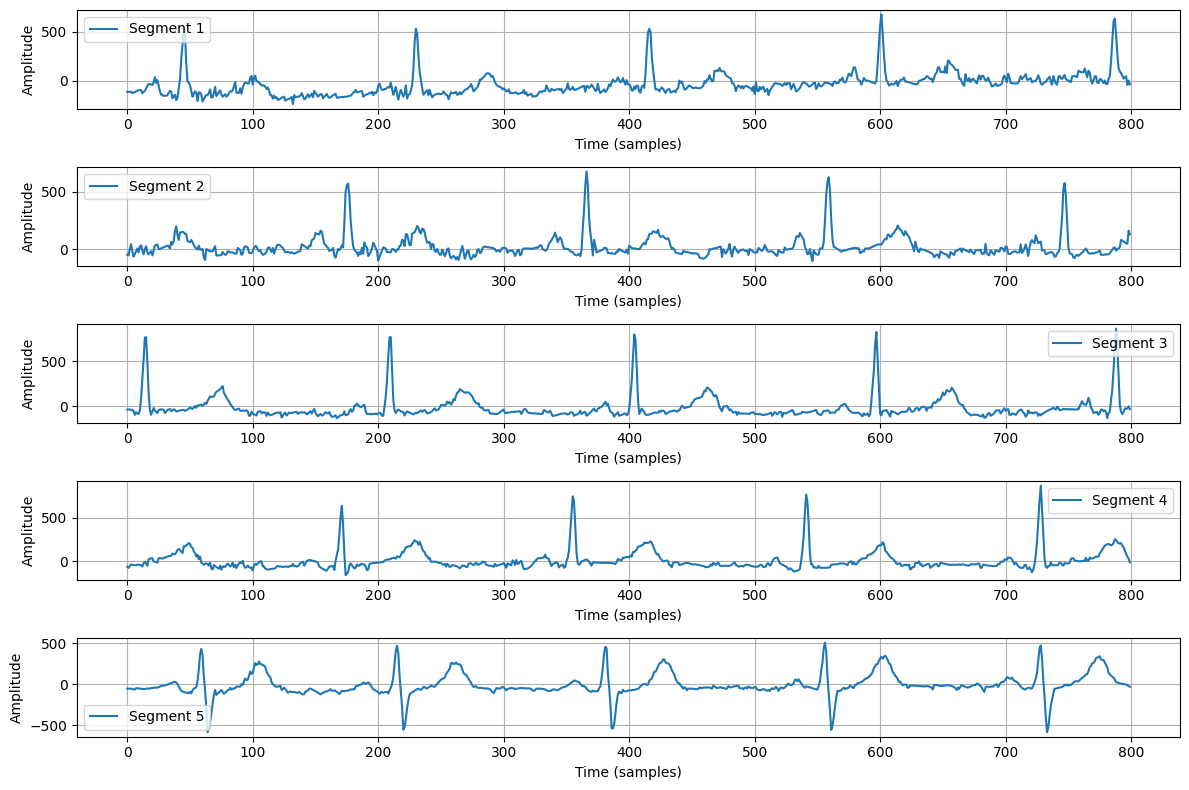

In [4]:
import matplotlib.pyplot as plt

num_segments = min(5, len(lr_ecg_segments))  

plt.figure(figsize=(12, 8))

for i in range(num_segments):
    plt.subplot(num_segments, 1, i + 1) 
    plt.plot(lr_ecg_segments[i], label=f'Segment {i+1}')
    plt.legend()
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.grid()

plt.tight_layout()
plt.show()

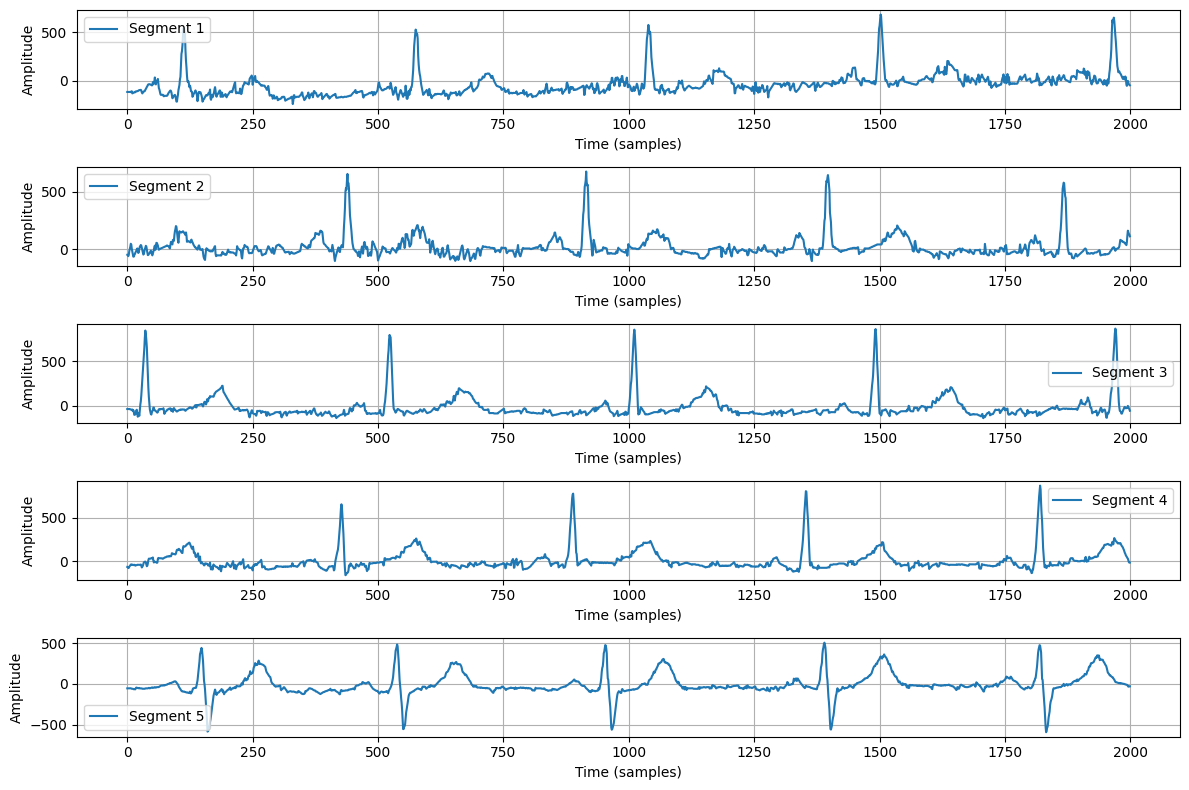

In [5]:
import matplotlib.pyplot as plt

num_segments = min(5, len(ecg_segments))  

plt.figure(figsize=(12, 8))

for i in range(num_segments):
    plt.subplot(num_segments, 1, i + 1) 
    plt.plot(ecg_segments[i], label=f'Segment {i+1}')
    plt.legend()
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.grid()

plt.tight_layout()
plt.show()

In [6]:
base_path = r"C:\Vinh\CSSALT\CSSALT-waveform-classify-model\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
metadata_path = os.path.join(base_path, "augmented_ecg_data.csv")  
vfib_df = pd.read_csv(metadata_path)
vfib_segments = vfib_df.to_numpy()

def replace_outliers(signal, threshold=1000):
    for i in range(len(signal)):
        if abs(signal[i]) > threshold:
            prev_value = signal[i - 1] if i > 0 else 0 
            next_value = signal[i + 1] if i < len(signal) - 1 else 0  
            signal[i] = (prev_value + next_value) / 2
    return signal

for vfib_segment in vfib_segments:
    replace_outliers(vfib_segment)

print(vfib_segments)
print(len(vfib_segments))

[[-120.72434608 -211.70142784 -268.2964205  ...  198.47019947
   144.28482312   12.5211549 ]
 [ -40.24144869 -139.17962828 -142.89251696 ...  362.93909082
   179.87199303   12.07521375]
 [ -80.48289738 -153.13560871 -231.75195941 ...  175.13483458
    87.34533057   12.50718704]
 ...
 [-160.96579477 -287.19425422 -363.23176856 ...  123.20060587
    23.6556075    16.68191397]
 [   0.            8.93268725   43.26224568 ...  190.42450771
    81.78078097  -29.08804546]
 [-181.08651911 -307.87950195 -458.37796498 ...   99.13712183
    92.36334115   -8.70452598]]
558


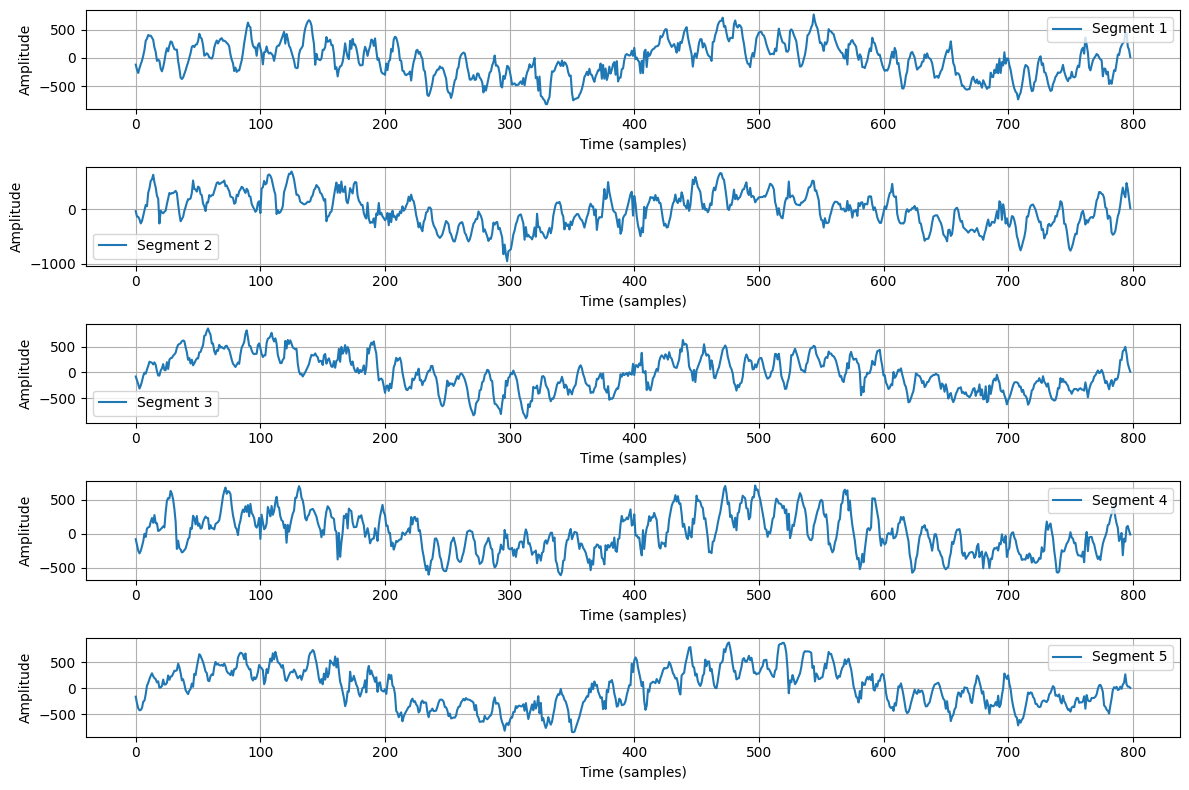

In [7]:
num_segments = min(5, len(vfib_segments))  

plt.figure(figsize=(12, 8))

for i in range(num_segments):
    plt.subplot(num_segments, 1, i + 1) 
    plt.plot(vfib_segments[i], label=f'Segment {i+1}')
    plt.legend()
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.grid()

plt.tight_layout()
plt.show()

In [8]:
import random
random.seed(42)
nsr_segments = np.array(random.sample(list(lr_ecg_segments), 558))
nsr_segments

array([[-160. , -160. , -160. , ...,  -45.5,  -40. ,  -45.5],
       [  25. ,   24.5,   25. , ...,  -70. ,  -70. ,  -75. ],
       [   5. ,    4.5,    5. , ...,  102. ,   80. ,   50.5],
       ...,
       [  15. ,   19.5,  -25. , ...,  258.5,  230. ,  204. ],
       [ 235. ,  235. ,  235. , ...,  -31. ,  -15. ,  -19. ],
       [  65. ,   71. ,   70. , ...,  -50. ,  -45. ,  -45. ]])

In [9]:
#confirm the shape of two input array
nsr_segments = nsr_segments[:, :-1]
print(nsr_segments.shape)
print(vfib_segments.shape)

(558, 799)
(558, 799)


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

nsr_labels = np.zeros(len(nsr_segments), dtype=np.int64) #label 0 for NSR
vfib_labels = np.ones(len(vfib_segments), dtype=np.int64) #Label 1 for VFib

x = np.vstack((nsr_segments, vfib_segments))
y = np.concatenate((nsr_labels, vfib_labels))

#normalize data
x = (x - np.mean(x))/np.std(x);

#convert to tensor
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

x = x.unsqueeze(1) #reshape input for 1D CNN (total_sample, 1, 800)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

torch.Size([892, 1, 799])
torch.Size([892])
torch.Size([224, 1, 799])
torch.Size([224])


In [11]:
x_train

tensor([[[-3.2483e-03, -4.6068e-03, -6.0084e-03,  ..., -7.8994e-05,
          -1.1661e-03, -2.1105e-03]],

        [[-1.9465e-03, -2.7166e-03, -2.4068e-03,  ..., -6.4406e-04,
          -1.6056e-03, -2.1356e-03]],

        [[-1.7038e-03, -1.7038e-03, -1.7038e-03,  ..., -3.4022e-03,
          -3.2162e-03, -2.9979e-03]],

        ...,

        [[-3.4110e-03, -4.3715e-03, -5.6613e-03,  ...,  1.0577e-03,
          -1.0651e-03, -3.6303e-03]],

        [[-4.5501e-03, -5.7815e-03, -6.6225e-03,  ...,  8.3247e-05,
          -1.2575e-03, -1.8077e-03]],

        [[-4.2247e-03, -4.6493e-03, -5.0462e-03,  ..., -1.4818e-03,
          -1.8194e-03, -1.6591e-03]]])

In [12]:
#our pytorch dataset class
class ECGDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
train_dataset = ECGDataset(x_train, y_train)
val_dataset = ECGDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

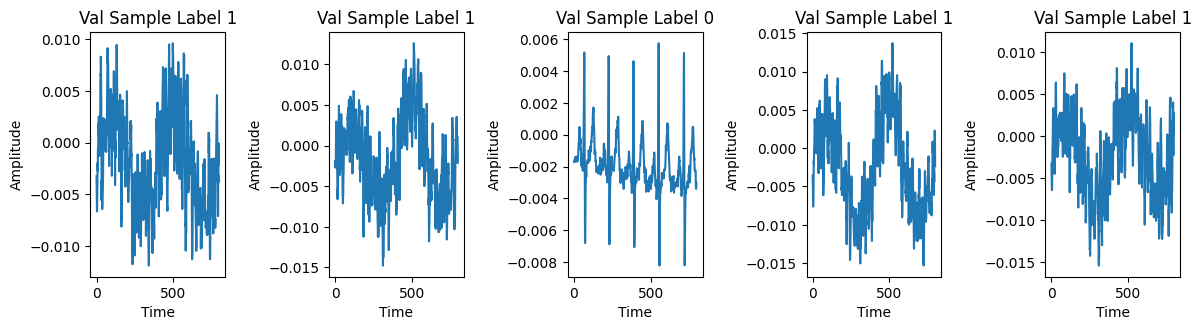

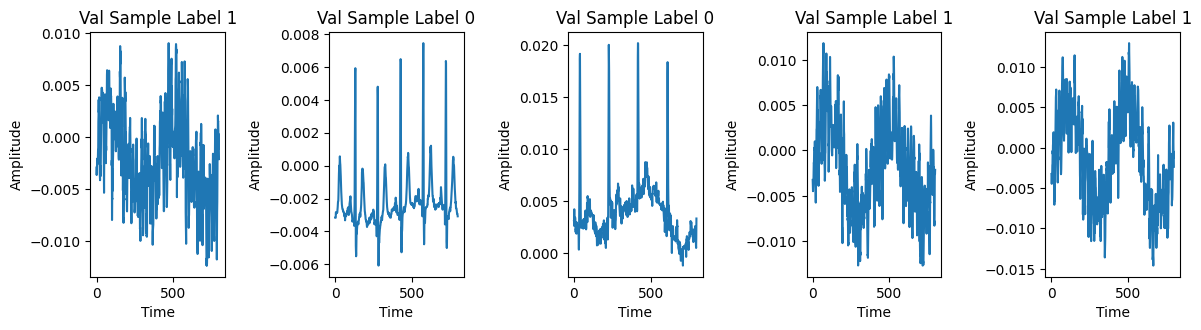

In [13]:
import matplotlib.pyplot as plt

#train dataset visualization
plt.figure(figsize=(12, 6))
for i in range(5):
    sample, label = train_dataset[i]  
    sample = sample.squeeze(0)  
    sample = sample.cpu().numpy()  
    plt.subplot(2, 5, i + 1)  
    plt.plot(sample) 
    plt.title(f"Val Sample Label {label}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

#val dataset visualization
plt.figure(figsize=(12, 6))
for i in range(5):
    sample, label = val_dataset[i] 
    sample = sample.squeeze(0)  
    sample = sample.cpu().numpy()  
    plt.subplot(2, 5, i + 1)  
    plt.plot(sample) 
    plt.title(f"Val Sample Label {label}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()



In [14]:
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

class ECG_CNN(nn.Module):
    def __init__(self):
        super(ECG_CNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.flatten_size = 64 * (799 // (2 * 2 * 2))  # size after 3 pooling layers

        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 1)  #output 1 value for binary classification (logit)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)

        x = torch.relu(self.conv2(x))
        x = self.pool2(x)

        x = torch.relu(self.conv3(x))
        x = self.pool3(x)

        #flatten the tensor to feed into fully connected layers
        x = x.view(x.shape[0], -1)  
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  

        return x  # raw logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECG_CNN().to(device)
summary(model, input_size=(1, 799)) 



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 799]              96
         MaxPool1d-2              [-1, 16, 399]               0
            Conv1d-3              [-1, 32, 399]           2,592
         MaxPool1d-4              [-1, 32, 199]               0
            Conv1d-5              [-1, 64, 199]          10,304
         MaxPool1d-6               [-1, 64, 99]               0
            Linear-7                  [-1, 128]         811,136
            Linear-8                    [-1, 1]             129
Total params: 824,257
Trainable params: 824,257
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.44
Params size (MB): 3.14
Estimated Total Size (MB): 3.59
----------------------------------------------------------------


In [15]:
criterion = nn.BCEWithLogitsLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001) 

num_epochs = 10
for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) 
        
        optimizer.zero_grad() 
        
        outputs = model(inputs)
        
        loss = criterion(outputs.squeeze(), labels.float())  
        loss.backward()  
        optimizer.step() 
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")



Epoch [1/10], Loss: 0.694615302341325
Epoch [2/10], Loss: 0.6920478301388877
Epoch [3/10], Loss: 0.688449672290257
Epoch [4/10], Loss: 0.6168834120035172
Epoch [5/10], Loss: 0.20309930999896356
Epoch [6/10], Loss: 0.011069251419810047
Epoch [7/10], Loss: 0.004511945901737947
Epoch [8/10], Loss: 0.004858451151189261
Epoch [9/10], Loss: 0.0028283675190842977
Epoch [10/10], Loss: 0.0018079021579719015


In [16]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, data_loader, device):
    model.eval()  
    all_preds = []
    all_labels = []
    all_probs = []  

    with torch.no_grad():  #no gradients needed for evaluation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()  

            #get probabilities using sigmoid
            probabilities = torch.sigmoid(outputs)

            preds = (probabilities >= 0.5).cpu().numpy().astype(int)  # label 1 if probabilities >= 0.5

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())  
            all_probs.extend(probabilities.cpu().numpy()) 

    cm = confusion_matrix(all_labels, all_preds)
    
    report = classification_report(all_labels, all_preds, target_names=["NSR", "VFib"])

    return cm, report, all_probs, all_labels, all_preds

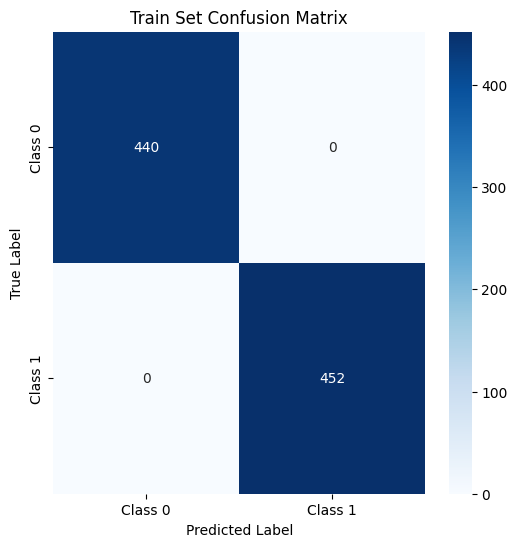

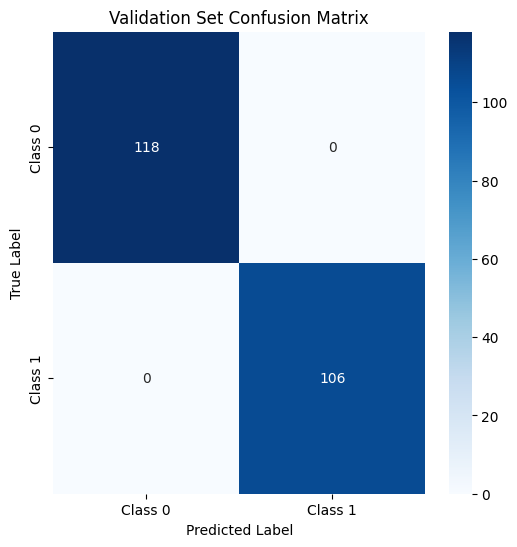

Train Classification Report:
              precision    recall  f1-score   support

         NSR       1.00      1.00      1.00       440
        VFib       1.00      1.00      1.00       452

    accuracy                           1.00       892
   macro avg       1.00      1.00      1.00       892
weighted avg       1.00      1.00      1.00       892


Validation Classification Report:
              precision    recall  f1-score   support

         NSR       1.00      1.00      1.00       118
        VFib       1.00      1.00      1.00       106

    accuracy                           1.00       224
   macro avg       1.00      1.00      1.00       224
weighted avg       1.00      1.00      1.00       224



In [17]:
import seaborn as sns

train_cm, train_report, train_probs, train_labels, train_preds = evaluate_model(model, train_loader, device)
val_cm, val_report, val_probs, val_labels, val_preds = evaluate_model(model, val_loader, device)

#display confusion matrix using seaborn heatmap
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(train_cm, title="Train Set Confusion Matrix")
plot_confusion_matrix(val_cm, title="Validation Set Confusion Matrix")

print("Train Classification Report:")
print(train_report)

print("\nValidation Classification Report:")
print(val_report)


In [18]:
print("Train Sample Labels and Probabilities:")
for label, prob in zip(train_labels[:10], train_probs[:10]):
    print(f"Label: {label}, Probability: {prob}")

print("\nVal Sample Labels and Probabilities:")
for label, prob in zip(val_labels[:10], val_probs[:10]):
    print(f"Label: {label}, Probability: {prob}")

Train Sample Labels and Probabilities:
Label: 0, Probability: 4.142039324506186e-05
Label: 1, Probability: 0.999954104423523
Label: 0, Probability: 8.085290755843744e-05
Label: 0, Probability: 1.3758289242105093e-05
Label: 0, Probability: 3.312619446660392e-05
Label: 1, Probability: 0.999908447265625
Label: 0, Probability: 3.143247158732265e-05
Label: 0, Probability: 3.1772749935043976e-05
Label: 1, Probability: 0.9999542236328125
Label: 1, Probability: 0.997262716293335

Val Sample Labels and Probabilities:
Label: 1, Probability: 0.8332547545433044
Label: 0, Probability: 6.486336496891454e-05
Label: 0, Probability: 0.00013174467312637717
Label: 1, Probability: 0.997577965259552
Label: 1, Probability: 0.9999456405639648
Label: 1, Probability: 0.9999256134033203
Label: 0, Probability: 4.384779458632693e-05
Label: 1, Probability: 0.9966256618499756
Label: 0, Probability: 0.00013223527639638633
Label: 1, Probability: 0.999430239200592
